## Basic Regression: Predict Full Efficiency
* aim is to predict the output of a cont. value

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [82]:
#Make numpy printouts easier to read
np.set_printoptions(precision = 5, suppress = True)

In [83]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Model

print(tf.__version__)

2.17.0


### Get the data

In [84]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(url, names=column_names,na_values='?', comment="\t",sep=' ', skipinitialspace=True)

In [85]:
dataset=raw_dataset.copy()
dataset.tail(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [86]:
# Clean the data
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [87]:
dataset= dataset.dropna()

In [88]:
# The next step is the one-hot encoding, numerize the non-numeric values
dataset["Origin"]=dataset["Origin"].map({1: 'USA' ,2: 'Europe', 3: 'Japan'})


In [89]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [90]:
# Split the data into taining and test datasets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

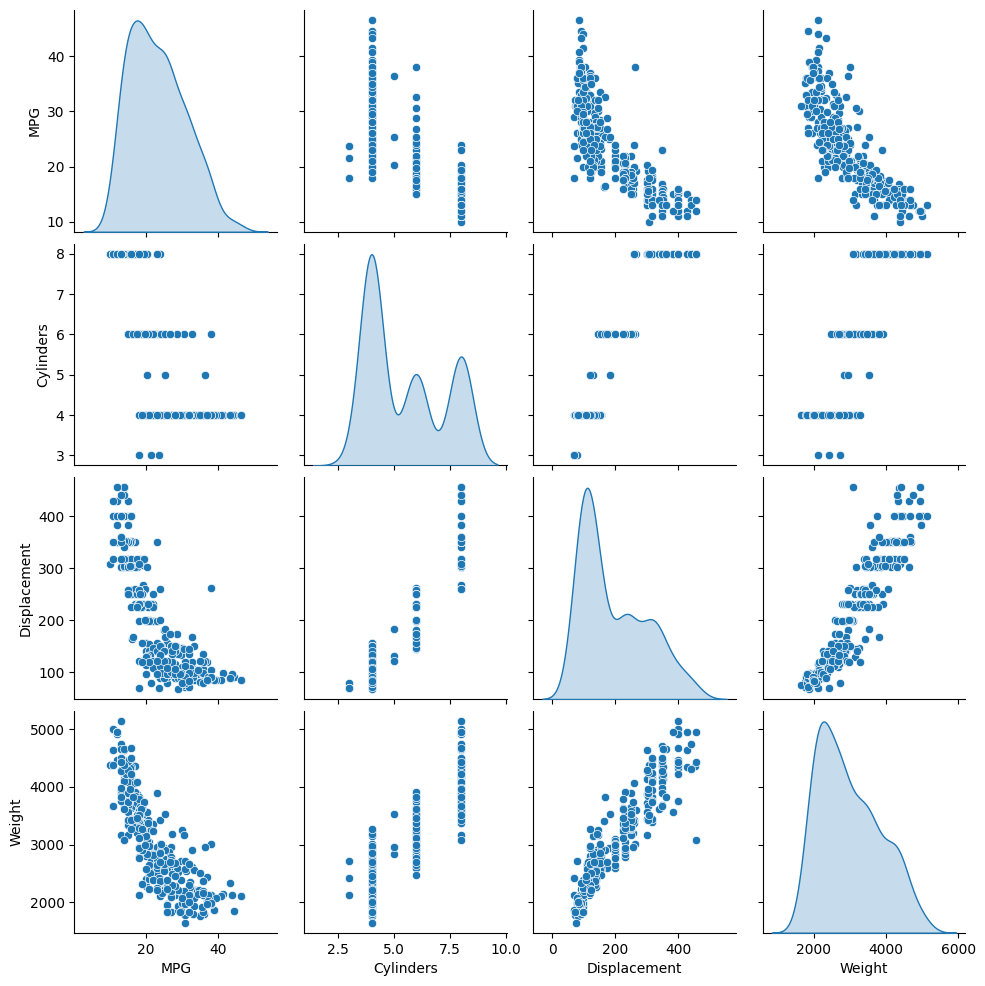

In [91]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [92]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [93]:
# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [94]:
# Normalization
train_dataset.describe().transpose()[["mean","std"]]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [95]:
# Normalization Layer
normalizer = tf.keras.layers.Normalization(axis=1)



In [96]:
normalizer.adapt(np.array(train_features))

In [97]:
print(normalizer.mean.numpy())

[[   5.47771  195.31847  104.86943 2990.2517    15.55924   75.89809
     0.17834    0.19745    0.6242 ]]


In [98]:
# When the layer is called, it returns the input data, with each feature independently normalized

first = np.array(train_features[:1]).astype('float32') # mistake corrected

with np.printoptions(precision=5, suppress=True):
    print("First example:", first)
    print()
    print("Normalized:", normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87074 -1.01107 -0.7853  -1.02694 -0.38037 -0.51722 -0.46589 -0.49602
   0.77591]]


# Linear Regression - FINALLY
Before building a **Deep-NN** model, swart with linear regression using one and several variables.

### Linear Regression with one variable
Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'
* Typically starts by defining the model architecture.
* Use a `tf.kreas.Sequential`model, which represents a sequence of steps.

Steps:
* Normalize the "Horsepower" input features using the `tf.keras.layers.Normalization` preprocessing layer.
* Apply a linear transformation to produce 1 output using a **linear layer** (`tf.keras.layers.Dense`)

The number of inputs can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [99]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

C:\Users\Özgür Nazlı\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
# Build the Keras Sequential model:

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1) # Linearity
])

In [101]:
# horsepower_model.summary()
# This model will predict "MPG" from "Horsepower" values. Run the untrained model on the first 10 "Horsepower" values. The output won't be good, but notice that it has the expected shape of (10,1):

In [102]:
horsepower_model.predict(horsepower[:10])
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), # Could be changed
    loss='mean_absolute_error')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [103]:
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [104]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806538,4.201391,95
96,3.804955,4.184411,96
97,3.802651,4.196884,97
98,3.803422,4.189202,98
99,3.802724,4.197407,99


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


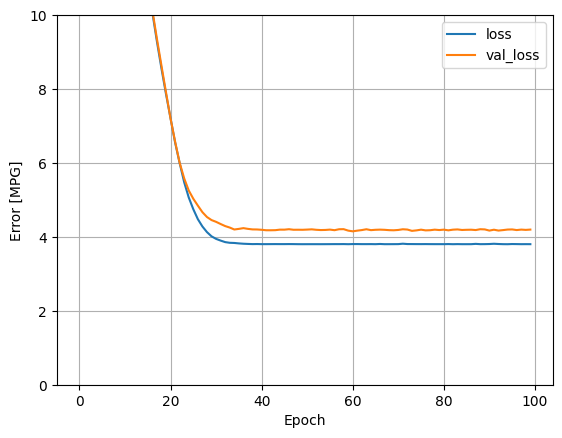

In [105]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

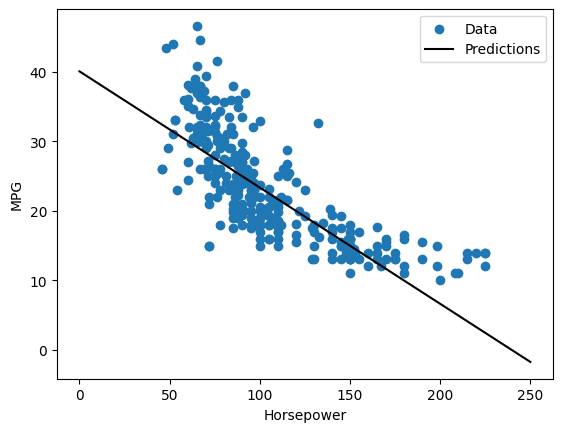

In [106]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()
plot_horsepower(x, y)

## Linear Regression With Multiple Inputs

This model is the same as one variable but y = mx+ b, m is a matrix and b is a vector 

Create atwo-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=1)`) you defied earlier and adapted to the whole dataset:


In [107]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call Model.predict on a batch of inputs, it produces units=1 outputs for each example:

In [108]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


array([[-1.86787],
       [-0.12013],
       [ 0.97973],
       [-0.75578],
       [-0.42262],
       [ 0.93341],
       [-0.3359 ],
       [ 1.87024],
       [ 0.04493],
       [-1.00501]], dtype=float32)

When you call the model, its weight matrices will be built- check that `kernel`weights (m's) have a shape of (9,1):

In [109]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_11/dense_11/kernel>

In [110]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), # optimizer could be changed
    loss='mean_absolute_error') # loss function could be changed 

In [111]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 6.61 s
Wall time: 5.71 s


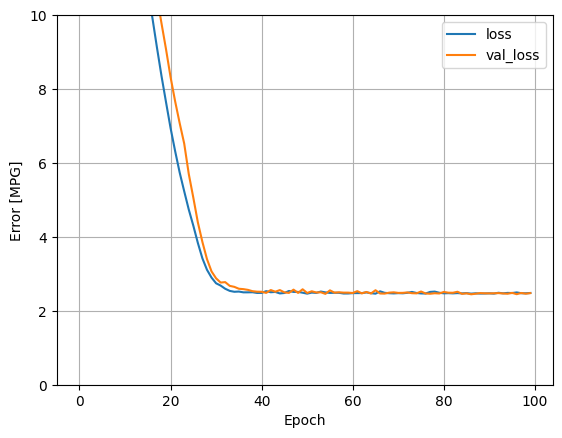

In [112]:
plot_loss(history)

In [113]:
# Collect the results on the test set for later:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Regression with a Deep Neural Network

Here you will single input and multiple input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer
* Two hidden, non-linear, Dense layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense`single-output layer.
Both mdeols will use the same training procedure, so the `compile`method is included in the `build_and_compile_model` function below.


In [116]:
# Function:

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss= 'mean_absolute_error',
                  optimizer= tf.keras.optimizers.Adam(0.001))
    return model

## Regression Using a DNN and a single input
* `Horsepower` as input
* `horsepower_normalizer` as the normalization layer:

In [118]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [119]:
dnn_horsepower_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras `Model.fit`

In [120]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 6.8 s
Wall time: 6.25 s


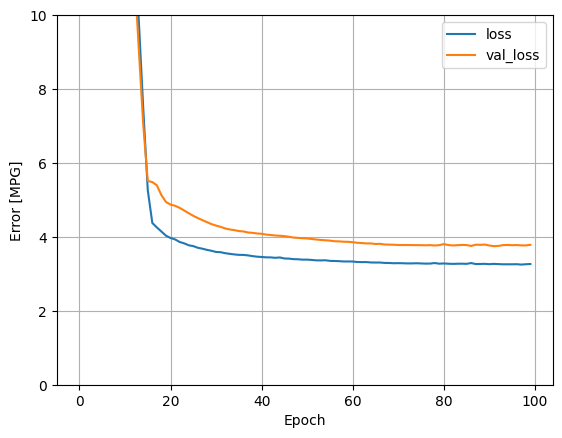

In [121]:
plot_loss(history)

In [122]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


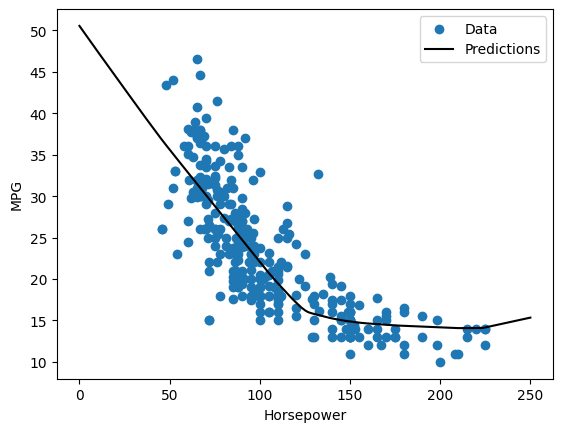

In [123]:
plot_horsepower(x, y)

In [125]:
#Collect the results on the test set for later:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Regression Using a DNN and Multiple Inputs
Repeat previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [126]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [127]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 6.73 s
Wall time: 6.14 s


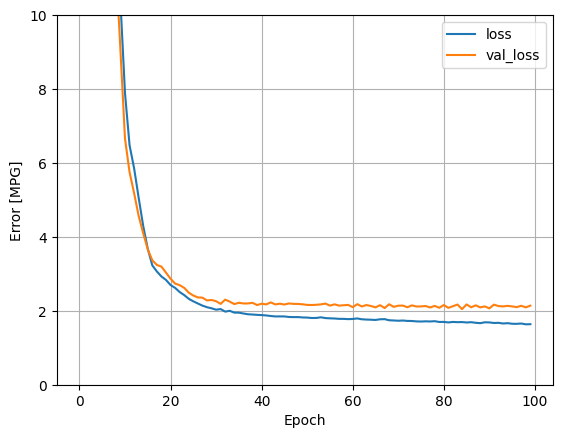

In [128]:
plot_loss(history)

In [129]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)